In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My Drive/Datasets/BIOSCAN
!ls

/content/drive/My Drive/Datasets/BIOSCAN
 Bioscan.ipynb		        MAP_utils.py	        __pycache__
 Bioscan_Test.ipynb	        medium_training.tsv     small_training.tsv
'Copia de Bioscan_Test.ipynb'   model_checkpoints       transformers_utils.py
 full_training.tsv	        model_checkpoints_new   unseen.tsv


In [3]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Load the libraries
from transformers_utils import BERT, SampleDNAData
from torch.utils.data import DataLoader
import pandas as pd
import umap
import torch
import numpy 
import matplotlib.pyplot as plt 




In [5]:
from transformers_utils import PabloDNADataset, tokenizer
from torch import nn
from transformers_utils import Embedding, EncoderLayer, GELU, get_attn_pad_mask

def get_all_kmers(k_mer_length, alphabet=None) -> list:

  def base_convert(num, base, length):
      result = []
      while num > 0:
          result.insert(0, num % base)
          num = num // base
      while len(result) < length:
          result.insert(0, 0)
      return result

  if alphabet is None:
      alphabet = ["A", "C", "G", "T", "-", "N"]
  k_mer_counts = len(alphabet) ** k_mer_length
  all_k_mers_list = []
  for i in range(k_mer_counts):
      code = base_convert(num=i, base=len(alphabet), length=k_mer_length)
      k_mer = ""
      for j in range(k_mer_length):
          k_mer += alphabet[code[j]]
      all_k_mers_list.append(k_mer)

  return all_k_mers_list


test_path = "unseen.tsv"
test_dataset = PabloDNADataset(test_path)


# Remove X,R,Y letters from data
test_dataset.change_RXY2N("nucleotides")
test_nucleotides = list(test_dataset.df["nucleotides"].values)
test_species = list(test_dataset.df["species_name"].values)

word_list = get_all_kmers(4)
word_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}
for i, w in enumerate(word_list):
    word_dict[w] = i + 4
    number_dict = {i: w for i, w in enumerate(word_dict)}


In [6]:
# DNABERT configuration
config = {
    "d_model": 768,
    "n_heads": 12,
    "n_layers": 12,
    "max_len":512
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BERT(len(word_dict), config["d_model"], config['max_len'], 2, config["n_layers"], 32, 32, config["n_heads"])

#Load the last model available from training
saving_path = "/content/drive/My Drive/Datasets/BIOSCAN/model_checkpoints_new/"
last_epoch = 50

model.load_state_dict(torch.load(saving_path + f'model_{last_epoch}.pth'))

<All keys matched successfully>

## Embedding


In [7]:
# This is not the most efficient way to do this - We should have a batch and
# a dataloader for testing. Sorry for now :(
CLS_embedding = []
embedding = []

n_samples = 1000
for seq in test_nucleotides[:n_samples]:
  tokens = tokenizer(seq, word_dict, 4, stride=1)
  input_ids = [word_dict['[CLS]']] + tokens + [word_dict['[SEP]']]
  segment_ids = [0] * (1 + len(tokens) ) + [1] * (1)
  masked_tokens, masked_pos = [], [] #No mask for testing
            
  # Zero Paddings
  n_pad = config['max_len'] - len(input_ids)
  input_ids.extend([0] * n_pad)
  segment_ids.extend([0] * n_pad)
  
  ids, seg, msk_pos = torch.Tensor(input_ids).type(torch.IntTensor), torch.Tensor(segment_ids).type(torch.IntTensor), torch.Tensor(masked_pos).type(torch.int64)

  #ids, seg, msk_pos = torch.cuda.IntTensor(input_ids), torch.cuda.IntTensor(segment_ids), torch.cuda.LongTensor(masked_pos)

  with torch.no_grad():
    out = model(ids.unsqueeze(1), seg.unsqueeze(1), msk_pos.unsqueeze(1))
    z1 = torch.squeeze(torch.mean(out[-1], 0, False)).cpu().numpy()  #GAP 
    z2 = out[-1][0, 0].cpu().numpy()  # First ['CLS'] token 
    embedding.append(z1)  #GAP to compute the hidden representations
    CLS_embedding.append(z2)

  

print(len(embedding))

1000


## ['CLS']

(1000, 768)
(1000, 2)


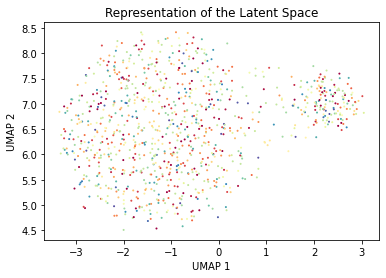

[0.031, 0.029, 0.028]
Best Metric:  manhattan Accuracy:  0.031


In [8]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import matplotlib.pyplot as plt


latent = np.array(CLS_embedding)
print(latent.shape)
unique_labels = list(np.unique(test_species[:n_samples]))
y_true = np.array(list(map(lambda x: unique_labels.index(x), test_species[:n_samples])))

fig, ax = plt.subplots(nrows=1, ncols=1) 
ax.set_title("Representation of the Latent Space")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

_embedding = umap.UMAP(random_state=42).fit_transform(latent)
print(_embedding.shape)

ax.scatter(_embedding[:, 0],
           _embedding[:, 1],
           c=y_true,
           s=1,
           cmap='Spectral')
plt.show()



## Histogram of Nearest Neighbors
metrics = ['manhattan', 'cosine', 'minkowski']
scores = []
neighbour_size = 1
gt = y_true
for metric in metrics:
    nbrs = NearestNeighbors(n_neighbors=neighbour_size+1, metric=metric).fit(embedding)
    _, neighbour_indices = nbrs.kneighbors(embedding)
    neighbour_indices = neighbour_indices.astype(np.int32)[:,1:]
    
    y_neighbors = gt[neighbour_indices]

    y_mode = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=y_neighbors)
    scores.append(np.sum(y_mode == gt)/n_samples)

print(scores)
print("Best Metric: ", metrics[scores.index(max(scores))], "Accuracy: ", max(scores))
best_metric = metrics[scores.index(max(scores))]

## Embedding - ['GAP']

(1000, 768)
(1000, 2)


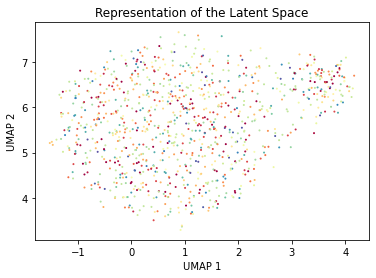

[0.031, 0.029, 0.028]
Best Metric:  manhattan Accuracy:  0.031


In [9]:
latent = np.array(embedding)
print(latent.shape)
unique_labels = list(np.unique(test_species[:n_samples]))
y_true = np.array(list(map(lambda x: unique_labels.index(x), test_species[:n_samples])))

fig, ax = plt.subplots(nrows=1, ncols=1) 
ax.set_title("Representation of the Latent Space")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

_embedding = umap.UMAP(random_state=42).fit_transform(latent)
print(_embedding.shape)

ax.scatter(_embedding[:, 0],
           _embedding[:, 1],
           c=y_true,
           s=1,
           cmap='Spectral')
plt.show()



## Histogram of Nearest Neighbors
metrics = ['manhattan', 'cosine', 'minkowski']
scores = []
neighbour_size = 1
gt = y_true
for metric in metrics:
    nbrs = NearestNeighbors(n_neighbors=neighbour_size+1, metric=metric).fit(embedding)
    _, neighbour_indices = nbrs.kneighbors(embedding)
    neighbour_indices = neighbour_indices.astype(np.int32)[:,1:]
    
    y_neighbors = gt[neighbour_indices]

    y_mode = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=y_neighbors)
    scores.append(np.sum(y_mode == gt)/n_samples)

print(scores)
print("Best Metric: ", metrics[scores.index(max(scores))], "Accuracy: ", max(scores))
best_metric = metrics[scores.index(max(scores))]

## Embedding - MAP - to-do
